In [57]:
# Import dependencies
import pandas as pd
import numpy as np
import os,sys
import json
import re
import matplotlib.pyplot as plt
from datetime import date, datetime
import dateparser
from pprint import pprint

DATA_DIR = "data"

In [26]:
datetime.now().replace(hour=0, minute=0, second=0).time()

datetime.time(0, 0, 0, 589064)

In [27]:
re.sub(r"([0-9]+)\.([0-9]+)", r"\1:\2", "7.15 a.m")

'7:15 a.m'

In [28]:
dateparser.parse("7 a.m.").time()

datetime.time(7, 0)

In [29]:
# Helper function for parsing time properly since the data is very unstructured
def parse_time(fts, cts, recurse=True):
    fine_time = ""
    coarse_time = ""
    orig_fts = fts
    orig_cts = cts
    
    stop_chars = ['.', ',']
    days = ["monday", "tuesday", "wednesday", 
            "thursday", "friday", "saturday", "sunday"]
    
    numbers = ["one", "two", "three", "four", "five", "six", 
               "seven", "eight", "nine", "ten", "eleven", "twelve"]
    
    # Get fine time from clock-time
    fts = fts.lower()
    fts = fts.replace("p. m.", "p.m.")
    fts = fts.replace("a.m.", "a.m.")
    fts = fts.strip()
    fts = re.sub(r"([0-9]+)\.([0-9]+)", r"\1:\2", fts)
    fts = re.sub(r"([0-9]+)[ ]*\:[ ]*([0-9]+)", r"\1:\2", fts)
    for i, number in enumerate(numbers):
        fts = fts.replace(number, str(i+1))
    
    while fts and not fts[0].isdigit():
        fts = fts[1:]
    if fts:
        try:
            fine_time = dateparser.parse(fts).time()
        except:
            # Just keep going if you couldn't figure it out
            _ = True
            #print("Fine Time Parse Error 1: '" + orig_fts + "'  |  '" + orig_cts + "'")
        
    # Get coarse time from time-day
    cts = cts.lower()
    coarse_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    
    for day in days:
        cts = cts.replace(day, '')
    for c in stop_chars:
        cts = cts.replace(c, '')
    cts = cts.replace('  ', ' ')
    cts = cts.strip()
    if cts == "":
        coarse_time = ""
    elif cts in ["early morning", "dawn"] or \
        ("early" in cts and "morning" in cts) or "wake" in cts:
        coarse_time = coarse_time.replace(hour=7)
    elif ("early" in cts and "afternoon" in "cts") or "noon" in cts or "lunchtime" in cts:
        coarse_time = coarse_time.replace(hour=12)
    elif cts in ["morning", "am", "am", "early"]:
        coarse_time = coarse_time.replace(hour=10)
    elif cts in ["afternoon", "pm", "mid-day", "midday"] or "after school" in cts:
        coarse_time = coarse_time.replace(hour=15)
    elif cts in ["night", "evening", "late"] or "night" in cts or "nigh" in cts \
        or "after business" in cts or "dinnertime" in cts:
        coarse_time = coarse_time.replace(hour=21)
    elif cts == "midnight" or "midnight" in cts:
        coarse_time = coarse_time.replace(hour=0)
    elif cts in ["overnight", "before dawn"]:
        #TODO: Make this the next day (maybe that doesn't matter)
        # .    Could be good enough to indicate "3am" or something
        # .    since the day doesn't matter when examining time of day
        # .    as an independent factor
        coarse_time = coarse_time.replace(hour=3)
    # Repeat this later in the priority list in case we hit "early afternoon" or something
    elif "early" in cts:
        coarse_time = coarse_time.replace(hour=10)
    else:
        coarse_time = ""
        if not fine_time:
            while cts and not cts[0].isdigit():
                cts = cts[1:]
            if cts:
                try:
                    fine_time = dateparser.parse(cts).time()
                except:
                    # Just keep going if you couldn't figure it out
                    _ = True
                    #print("Coarse Time Parse Error 1: '" + orig_fts + "'  |  '" + orig_cts + "'")
    # If no time was found, switch the two and try to parse
    # This helps because sometimes the coarse time has something like "2 a.m" 
    # and the fine time has something like "midnight"
    if coarse_time:
        coarse_time = coarse_time.time()
    if recurse and not fine_time and not coarse_time:
        fine_time, coarse_time = parse_time(orig_cts, orig_fts, recurse=False)
    return fine_time, coarse_time

In [39]:
def parseAddress(address):
    if not address:
        return None
    a = [_.strip() for _ in address.split(",")]
    cur = -1
    country = a[cur]
    cur -= 1
    zcode = None
    state = None
    # State and Zip have no comma
    if len(a[cur]) > 5:
        zcode = a[cur].split(" ")[1]
        state = a[cur].split(" ")[0]
        cur -= 1
    # Has zip
    elif len(a[cur]) > 2: 
        zcode = a[cur]
        cur -= 1
        state = a[cur]
        cur -= 1
    # Doesn't have zip
    else:
        state = a[cur]
        cur -= 1
    city = a[cur]
    return city, state, zcode, country

In [71]:
counties_map_raw = pd.read_csv(os.path.join(DATA_DIR, "us_cities_states_counties.csv"), delimiter="|")
counties_map = {}
counties_map_alias = {}
for index, row in counties_map_raw.iterrows():
    state = row["State short"]
    city = row["City"]
    city_alias = row["City alias"]
    county = row["County"]
    
    if state not in counties_map:
        counties_map[state] = {}
    if city not in counties_map[state]:
        counties_map[state][city] = county
    
    if state not in counties_map_alias:
        counties_map_alias[state] = {}
    if city_alias not in counties_map[state]:
        counties_map_alias[state][city_alias] = county

In [ ]:
# Pull in data and clean/organize it
events_raw = pd.read_csv(os.path.join(DATA_DIR, "Events.tsv"), delimiter="\t")
events_raw.columns = ["Address", "Date", "Details", "Participants"]
events = pd.DataFrame(columns=["Address", "Details", "Date", "Fine Time", 
                               "Coarse Time", "Shots Fired", "Gun Type",
                               "Participants"])
for index, event in events_raw.iterrows():
    new_event = {}
    new_event["Address"] = event["Address"]
    new_event["Date"] = datetime.strptime(event["Date"][:-6], 
                                          "%Y-%m-%d %H:%M:%S").date()
    # Incorrect date entry
    if new_event["Date"].year == 2026:
        new_event["Date"] = new_event["Date"].replace(year=2016)
    event_details = json.loads(event["Details"])
    fine_time, coarse_time = parse_time(event_details["clock-time"]["value"], 
                                    event_details["time-day"]["value"])
    new_event["Details"] = event_details["details"]["value"]
    new_event["Fine Time"] = fine_time
    new_event["Coarse Time"] = coarse_time
    new_event["Shots Fired"] = event_details["number-of-shots-fired"]["value"]
    new_event["Gun Type"] = event_details["type-of-gun"]["value"]
    new_event["Participants"] = event["Participants"]
    events = events.append(new_event, ignore_index=True)

In [33]:
# Take only data from US after 2000
usa_indices = []
date_2000 = date(2010, 1, 1)
for index, event in events.iterrows():
    address = event["Address"]
    if address.endswith("USA") and event["Date"] > date_2000:
        usa_indices.append(index)
usa_events = events.iloc[usa_indices]

In [34]:
usa_events

,Address,Details,Date,Fine Time,Coarse Time,Shots Fired,Gun Type,Participants
0,"Phoenix, AZ, USA",North 43rd Avenue and West Cactus Road,2016-02-26,04:45:00,,,,"[{u'injured': False, u'name': u'Alex Buckner',..."
1,"S Milwaukee Ave, Lake Villa, IL 60046, USA",Interstate 43 through downtown,2015-12-08,10:10:00,,more than a dozen,,"[{u'injured': True, u'name': u'', u'hospitaliz..."
2,"Milwaukee, WI, USA",northern Milwaukee,2015-08-02,17:00:00,,,handguns,"[{u'injured': True, u'name': u'', u'hospitaliz..."
3,"Phoenix, AZ, USA",near North 43rd Avenue and West Cactus Road,2016-02-23,,,,,"[{u'injured': False, u'name': u'Alex Buckner',..."
4,"Utica, NY, USA",,2016-02-21,,,,,"[{u'injured': False, u'name': u'Jamal Funes', ..."
5,"Utica, NY, USA",Avenue P and East 14th Street,2016-01-28,11:00:00,,,,"[{u'injured': True, u'name': u'', u'hospitaliz..."
6,"Columbia, SC, USA",Richland Terrace apartments off Metze Road,2015-02-08,20:30:00,21:00:00,,,"[{u'injured': False, u'name': u'', u'hospitali..."
7,"Chicago, IL, USA",87th and State,2016-02-22,,,,,"[{u'injured': False, u'name': u'', u'hospitali..."
8,"Oklahoma City, OK, USA",500 block of Northwest 114th Street,2015-08-04,21:10:00,21:00:00,,AR-15,"[{u'injured': False, u'name': u'Lasandra Gilbe..."
9,"Columbia, SC, USA",River Drive,2015-07-27,,21:00:00,,,"[{u'injured': False, u'name': u'', u'hospitali..."


In [166]:
# Collect data on dates and times of shootings
# Prefer Fine Time to Coarse Time if the record has it
event_dates = []
event_times = []
for index, event in usa_events.iterrows():
    event_dates.append(event["Date"])
    if event["Fine Time"]:
        event_times.append(event["Fine Time"])
    else:
        event_times.append(event["Coarse Time"])

In [126]:
# Create bar charts of # events by year and # events by time of day
num_events_by_year = []
years = range(2000, 2018)
for year in years:
    start = date(year, 1, 1)
    end = date(year, 12,31)
    events_in_year = len([d for d in event_dates if d >= start and d <= end])
    num_events_by_year.append(events_in_year)
    
num_events_by_tod = []
time_ranges = [(0, 6), (6, 12), (12, 18), (18, 0)]
for tr in time_ranges:
    start = datetime.now().replace(hour=tr[0], minute=0, second=0, microsecond=0).time()
    end = datetime.now().replace(hour=(tr[1]-1) % 24, minute=59, second=59, microsecond=0).time()
    events_in_time_range = len([t for t in event_times if t and t >= start and t <= end])
    num_events_by_tod.append(events_in_time_range)
    
num_empty_times = len([t for t in event_times if not t])

print("%d total events" % len(event_times))
print("%d events with no time" % num_empty_times)

Text(0,0.5,'Number of Gun Violence Events')

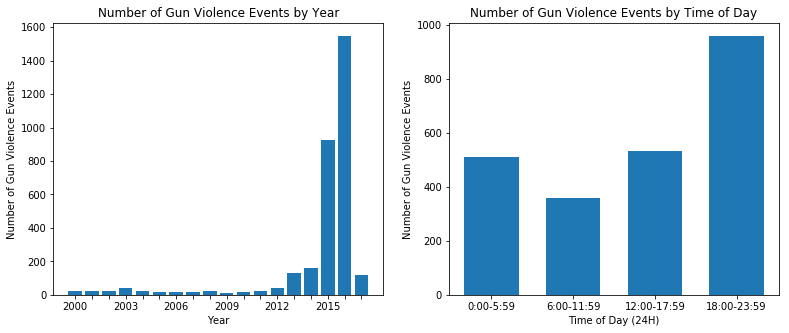

In [165]:
# Show the graphs
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].bar(years, num_events_by_year, tick_label=[str(year) if i % 3 == 0 else "" for i, year in enumerate(years)])
ax[0].set_title("Number of Gun Violence Events by Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Number of Gun Violence Events")

ax[1].bar([tr[0] for tr in time_ranges], num_events_by_tod, width=4,
        tick_label=["0:00-5:59", "6:00-11:59", "12:00-17:59", "18:00-23:59"])
ax[1].set_title("Number of Gun Violence Events by Time of Day")
ax[1].set_xlabel("Time of Day (24H)")
ax[1].set_ylabel("Number of Gun Violence Events")

The first graph indicates that our data is very heavily biased towards more recent events, and specifically 2016. No other data source cites a climb in gun violence of 800% from 2014 to 2016, so this bias is likely from more recent reports being available, or the data collection process.

The second graph indicates that between 6PM and midnight is the most likely time for gun violence to occur. It is roughly twice as likely in that time range than in any other.

In [101]:
# city, state, zcode, country
count = 0

city_reps = {"AR": {"Helena-West Helena":"West Helena",
                    "DeWitt":"Dewitt"},
            "CA": {"South Whittier":"Whittier"},
            "FL": {"Opa-locka":"Opa Locka"},
            "GA": {"LaGrange":"Lagrange"},
            "IA": {"DeWitt":"Dewitt"},
            "KS": {"Alta Mills":"Newton"},
            "MD": {"Greater Landover":"Landover"},
            "MI": {"Mt Morris Township":"Mount Morris",
                   "Calumet Twp":"Calumet"},
            "MT": {"Bonner-West Riverside":"Bonner"},
            "NC": {"McLeansville": "Mcleansville"},
            "NJ": {"Lafayette Township":"Lafayette",
                   "Bethlehem":"Califon"},
            "NY": {"Hartland":"Burt"},
            "OK": {"McAlester":"Mcalester"},
            "PA": {"West Conshohocken":"Conshohocken",
                   "McKeesport":"Mckeesport",
                   "Bensalem Township":"Bensalem",
                   "Wilkes-Barre": "Wilkes Barre"},
            "TX": {"Falcon Mesa":"Falcon"}
            }

for full_addr in usa_events["Address"]:
    addr = parseAddress(full_addr)
    city = addr[0]
    state = addr[1]
    
    # Cleanup city name
    if state in city_reps and city in city_reps[state]:
        city = city_reps[state][city]
        
    city = city.replace("St.", "Saint")
    city = city.replace("Ste.", "Sainte")
    city = city.replace("ñ", "n")
    city = city.replace("-", " ")
    if city[:3] == "Mt ":
        city = "Mount " + city[3:]
    if city[:3] == "St ":
        city = "Saint " + city[3:]

    county = None
    if city in counties_map[state]:
            county = counties_map[state][city]
    elif city in counties_map_alias[state]:
            county = counties_map_alias[state][city]
    else:
        print(addr)
        count += 1
print(count)

('Bridgeport Charter Township', 'MI', None, 'USA')
('Glendale', 'IL', '62985', 'USA')
('Florence-Graham', 'CA', '90001', 'USA')
('Kalamazoo Twp', 'MI', None, 'USA')
('DeForest', 'WI', None, 'USA')
('Feltonville', 'NC', '27540', 'USA')
('Dacusville', 'SC', '29640', 'USA')
('San Antonio', 'CA', '94952', 'USA')
('DeKalb', 'IL', None, 'USA')
('Phoenix', 'LA', '70040', 'USA')
('Fargo', 'AR', '72021', 'USA')
('White', 'NJ', None, 'USA')
('Upper Deerfield Township', 'NJ', None, 'USA')
('Warwick Township', 'PA', None, 'USA')
('Pennyhill', 'DE', '19809', 'USA')
('Manchester-by-the-Sea', 'MA', '01944', 'USA')
('Fair Hill', 'MD', '21921', 'USA')
('Ashford', 'WI', '53010', 'USA')
('Charter Twp of Clinton', 'MI', None, 'USA')
('Willowbrook', 'CA', None, 'USA')
('Davis Creek', 'WV', '25314', 'USA')
('Florence-Graham', 'CA', None, 'USA')
('Mt Morris', 'WI', '54982', 'USA')
23
